# Group 1: Dilute Solute Diffusion

In [1]:
!pip install kneed
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=93acc5f0418706524227cdf340ebfbb0b0fc92600aa27fd0f249e762037fa716
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [2]:
#this has all the imports from the other collab file. You don't need to include any in your individual parts
from tensorflow import keras

import tensorflow as tf
import random as python_random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import pickle
import io
import minisom
from minisom import MiniSom
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

Uploading Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Dilute_Solute_Diffusion_with_features.csv to Dilute_Solute_Diffusion_with_features.csv


In [4]:
import io
df = pd.read_csv('Dilute_Solute_Diffusion_with_features.csv')
print(df.head())
print(df.columns)

  Material compositions 1 Material compositions 2  Enorm (eV)  E_raw (eV)  \
0                      Ag                      Ag    0.000000    1.824450   
1                      Ag                      Co   -0.090142    1.734308   
2                      Ag                      Cr    0.259139    2.083589   
3                      Ag                      Cu   -0.022200    1.802250   
4                      Ag                      Fe    0.317672    2.142122   

   Site2_MeltingT  Site1_MendeleevNumber  Site1_MiracleRadius  \
0       -0.531814               0.402504             0.263045   
1        0.064051               0.402504             0.263045   
2        0.524584               0.402504             0.263045   
3       -0.394504               0.402504             0.263045   
4        0.112116               0.402504             0.263045   

   GSestFCClatcnt_max_value  Site2_BCCenergy_pa  Site1_BCCfermi  ...  \
0                 -0.626925            1.021337       -1.217816  ...   
1 

#Introduction

We want to use the data to create models that can predict the host element based on the other properties in the data set. As an initial screening method, we wanted to use a measure of association between variables to see if there are any features that we can exclude from our model to minimize overfitting. Since site one material is a nominal variable, we use Cramers V to determine the measure of association.

In [5]:
#this is a function for calculating the cramer's V value
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

<ipython-input-5-76ad6e1761b4>:11: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


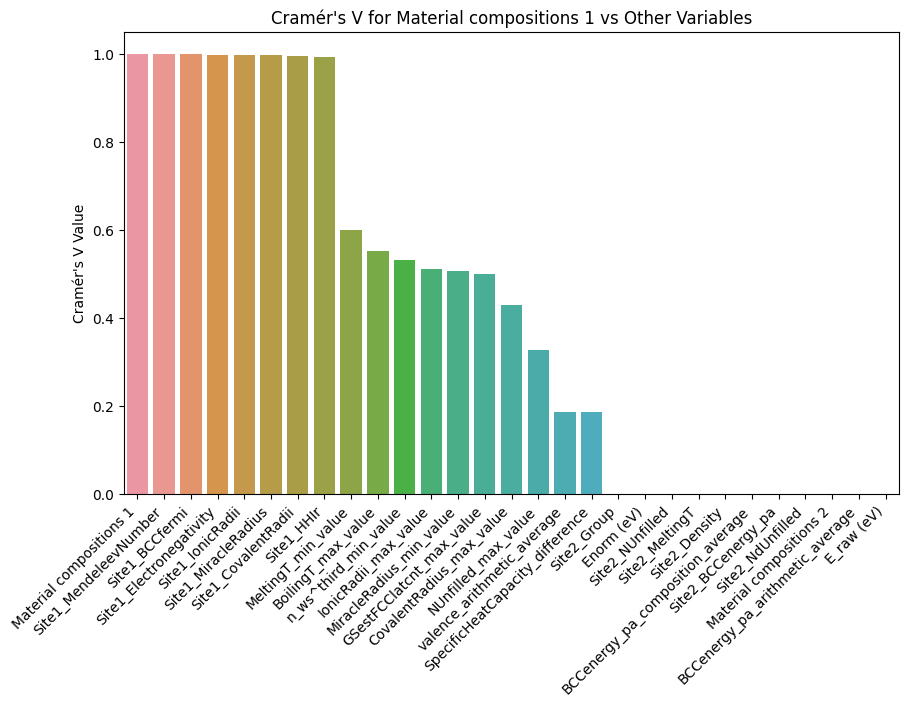

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
material_compositions_1 = "Material compositions 1"

# Calculate Cramér's V for "Material compositions 1" and all other variables
associations = pd.Series(index=df.columns, dtype=float)

for var in df.columns:
    cramers_v_value = cramers_v(df[material_compositions_1], df[var])
    associations[var] = cramers_v_value
associations = associations.sort_values(ascending=False)
# Visualize the associations in a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=associations.index, y=associations.values)
plt.title(f'Cramér\'s V for {material_compositions_1} vs Other Variables')
plt.ylabel('Cramér\'s V Value')
plt.xticks(rotation=45, ha="right")
plt.show()

When calculating the association values, we see that most of the material 1 properties have very high measures of association which is expected. We then selected the features that had a correlation above 0.2 and used this subset of data for further investigation.

In [7]:
association_1 = associations[associations != 0].copy()
association_2 = associations[(associations <= 0.95)].copy()
association_1 = association_1.iloc[:-1]
association_2=association_2.iloc[:-10]


In [8]:
#select columns that have a significant correlation of above 0.2 to decrease the number of features
df_updated = df[association_1.index]
df_updated_partial=df[association_2.index]

print(df_updated)

    Material compositions 1  Site1_MendeleevNumber  Site1_BCCfermi  \
0                        Ag               0.402504       -1.217816   
1                        Ag               0.402504       -1.217816   
2                        Ag               0.402504       -1.217816   
3                        Ag               0.402504       -1.217816   
4                        Ag               0.402504       -1.217816   
..                      ...                    ...             ...   
403                      Zr              -1.610722       -1.115927   
404                      Zr              -1.610722       -1.115927   
405                      Zr              -1.610722       -1.115927   
406                      Zr              -1.610722       -1.115927   
407                      Zr              -1.610722       -1.115927   

     Site1_Electronegativity  Site1_IonicRadii  Site1_MiracleRadius  \
0                   0.099471          3.316369             0.263045   
1                

#Hypothesis

Our hypothesis is that higher dimensional modeling of the dataset will yield relationships between the selected features in our subset, and that these relationships will allow us to classify the materials based on their host materials.

#Modeling

Here, we used multiple higher dimensional models to look for a relationship between the features that we selected. The models that we ended up choosing are k-means, SOM, and artificial neural networks.

#K-means Model

We first set up the dataset to be in a format that can be used in k-means clustering and then set up the parameters for the the clustering process.

In [9]:
df_kmeans = df_updated
features = df_kmeans.columns[1:]
target = ['Material compositions 1']
features_target = np.concatenate((features, target), axis=0)

x = df_kmeans.loc[:, features]
y = df_kmeans.loc[:, target]

In [10]:
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(x.values)

n_clusters = 15
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

The number of clusters was chosen to be 15 since that is the number of host elements originally in the dataset and we are trying to cluster the points into their hosts.

In [11]:
clusterer = KMeans(n_clusters,**kmeans_kwargs)
clusterer.fit(x.values)

cluster_labels = clusterer.labels_

In [12]:
x_withhost = x
x_withhost['host'] = df_kmeans['Material compositions 1']

In [13]:
# The lowest SSE value
print('SSE value: ', clusterer.inertia_)
print()

# Final locations of the centroid
print('Centroids locations: \n',clusterer.cluster_centers_)
print()

# The number of iterations required to converge
print('Num iterations for convergence: ', clusterer.n_iter_)
print()

SSE value:  2022.6916407427561

Centroids locations: 
 [[ 0.83109013 -0.56951257 -1.35185497 -0.06889417  0.9948153   0.37728244
  -0.85086667 -0.61811595 -0.46967124 -1.18490111  1.38339241  1.71141091
   1.81624385  2.35017013  1.71819778 -1.07098577  1.53437606]
 [-0.02473318 -0.56001014 -0.02215927 -0.06046821 -1.02038503 -0.99527228
  -0.56422255 -0.02852187 -0.63691369  0.48996295 -0.49203468 -0.96849634
  -0.83254184 -1.09010917 -0.63963034 -0.25862106 -0.48349627]
 [ 0.12555249  0.46576474  0.9285605  -0.29906827 -0.03214416  0.18562917
   1.91849163  1.18030623  0.39691377  1.26058703 -0.76664785  0.078761
  -0.81872824 -0.28598287 -0.20559944  0.5932153  -0.57708222]
 [ 0.12859592  0.44224548  0.92994679 -0.29862322 -0.02812799  0.18804236
   1.91607046 -0.58842449 -0.2001793  -0.20619864  0.58154114  0.32781922
  -0.40025211 -0.6732817  -1.36031599 -0.81849403 -0.68135933]
 [ 0.11772015 -0.61604296  0.21104965  0.21561642 -0.86975281 -0.80766388
  -0.57964973  0.47919387  0.

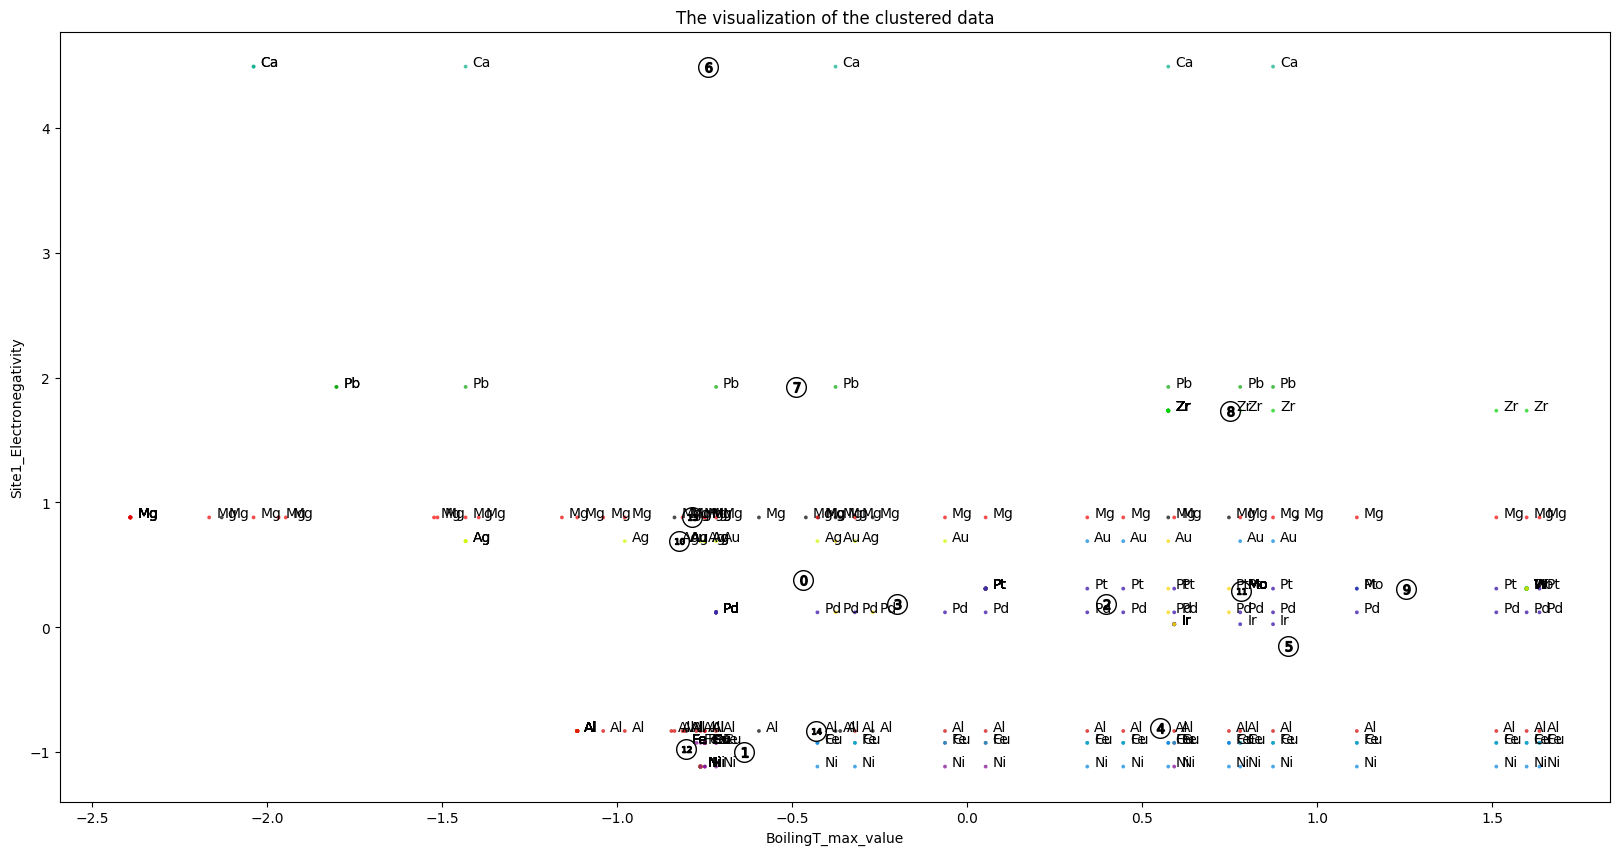

In [14]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.figure(figsize=(20,10))

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter( x_withhost['BoilingT_max_value'],x_withhost['Site1_CovalentRadii'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

for index, row in x_withhost.iterrows():
    plt.text(row['BoilingT_max_value']+.02, row['Site1_CovalentRadii'], str(row['host']))

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 8], centers[:, 5], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[8], c[5], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

plt.title("The visualization of the clustered data")
plt.ylabel("Site1_Electronegativity")
plt.xlabel("BoilingT_max_value")

plt.show()

In [15]:
for index, row in x_withhost.iterrows():
  print(index)
  print(row)
  break

0
Site1_MendeleevNumber              0.402504
Site1_BCCfermi                    -1.217816
Site1_Electronegativity            0.099471
Site1_IonicRadii                   3.316369
Site1_MiracleRadius                0.263045
Site1_CovalentRadii                0.690287
Site1_HHIr                        -0.589846
MeltingT_min_value                -0.046109
BoilingT_max_value                -1.432543
n_ws^third_min_value               -0.19392
IonicRadii_max_value               1.636881
MiracleRadius_min_value            0.859808
GSestFCClatcnt_max_value          -0.626925
CovalentRadius_max_value          -0.423908
NUnfilled_max_value               -1.546561
valence_arithmetic_average        -1.676966
SpecificHeatCapacity_difference   -1.057898
host                                     Ag
Name: 0, dtype: object


##SOM Model

In [16]:
df_SOM = df_updated
df_SOM['host'] = df['Material compositions 1']


<ipython-input-16-817f38a706a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SOM['host'] = df['Material compositions 1']


In [17]:
##SOM
df_updated = df[association_1.index]
#label training data
traindata = df_updated.iloc[:,1:].values
#determine minimum size
N = traindata.shape[0]
print("number of data points N = ", N)
print("minimum height and width = ", np.round(np.sqrt((5*np.sqrt(N)))))

number of data points N =  408
minimum height and width =  10.0


We then optimized the model by looking at topographic error (te) and  quantization error(qe)

Loops through to cycle through a range of sigma and size values and then calculates the te and qe. Displays these values in a 3D plot.  Using the plot and the minimum of both errors, moving forward we will use a size of 10 and a sigma value of 4.

/usr/local/lib/python3.10/dist-packages/minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


0.012254901960784314 1.4649633956155377
(10, 6)
(24, 4)


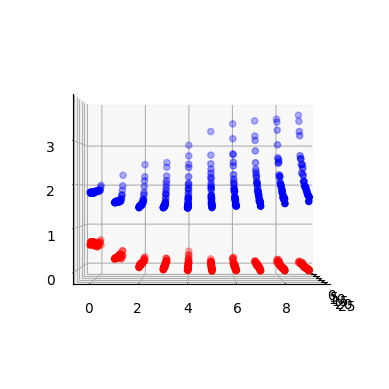

In [18]:
#finding best sigma ans size value
sig_list = np.arange(0.5,5.5,0.5)
size_list = np.arange(5,30,1)
te = {}
qe = {}


for j in range(len(size_list)):
  for i in range(len(sig_list)):
    som1 = MiniSom(size_list[j], size_list[j], traindata.shape[1], sigma=sig_list[i], learning_rate=0.5,neighborhood_function='gaussian', random_seed=0)
    som1.pca_weights_init(traindata)
    som1.train(traindata, 400)
    te[(j,i)] = som1.topographic_error(traindata)
    qe[(j,i)] = som1.quantization_error(traindata)

min_te = min(te.values())
min_te_values = min(te, key = te.get)
min_qe = min(qe.values())
min_qe_values = min(qe, key = qe.get)

print(min_te, min_qe)
print(min_te_values)
print(min_qe_values)

x=[]
y=[]
z_te=[]
z_qe = []

for item in te:
  x.append(item[0])
  y.append(item[1])
  z_te.append(te[item])
  z_qe.append(qe[item])

ax = plt.axes(projection='3d')
ax.scatter3D(x,y,z_te,c= 'red')
ax.scatter3D(x,y,z_qe, c = 'blue')
ax.view_init(0, 0)

In [19]:
# Define a SOM
height = 10
width = 10
size = 10
# Define a MiniSom object
som = MiniSom(width, height, traindata.shape[1], sigma=4.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)

# Initialize the weights by PCA
som.pca_weights_init(traindata)

# trains the SOM with 400 iterations
som.train(traindata, 400)

Look for clustering of material one composition(host) in the SOM.  Each host material is labeled with a different color

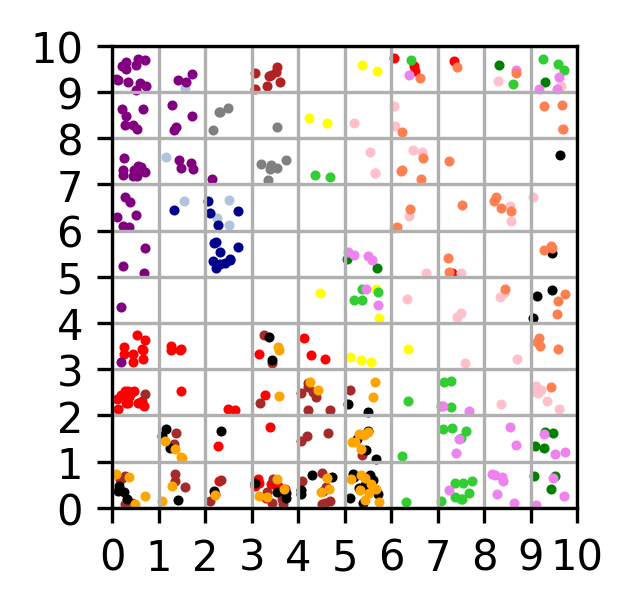

In [20]:
fig = plt.figure(figsize=(2, 2),dpi=300)
ax = fig.add_subplot(111)

colors = {'Ag':'grey', 'Al':'red', 'Au': 'yellow', 'Ca':'lightsteelblue', 'Cu': 'brown', 'Fe': 'black', 'Ir': 'green', 'Mg':'purple', 'Mo': 'pink', 'Ni': 'orange', 'Pb':'firebrick',
       'Pd': 'limegreen', 'Pt': 'violet', 'W': 'coral', 'Zr': 'darkblue'}

for index, datapoint in enumerate(traindata):
    w = som.winner(datapoint)

    #add a random offset to their coordinate in the grid
    x_coord = w[0]+np.random.uniform(0.05,0.75)
    y_coord = w[1]+np.random.uniform(0.05,0.75)

    color = colors[df_SOM.iloc[index]['host']]
    plt.scatter(x_coord,y_coord, c=color,s=2)



plt.xlim(0,size)
plt.ylim(0,size)
ax.set_xticks(range(width+1))
ax.set_yticks(range(height+1))
plt.grid()
plt.show()

In [21]:
W = som.get_weights()
W.shape
X = W.reshape(size**2, 17)

## K-means on SOM
Before using K-means on the SOM, we use both the silhouette and elbow method to find the optimal amount of clusters. Both methods suggest that using **6 clusters** is the best to maximize the silhoutte coefficient and minimize the SSE on the elbow point.

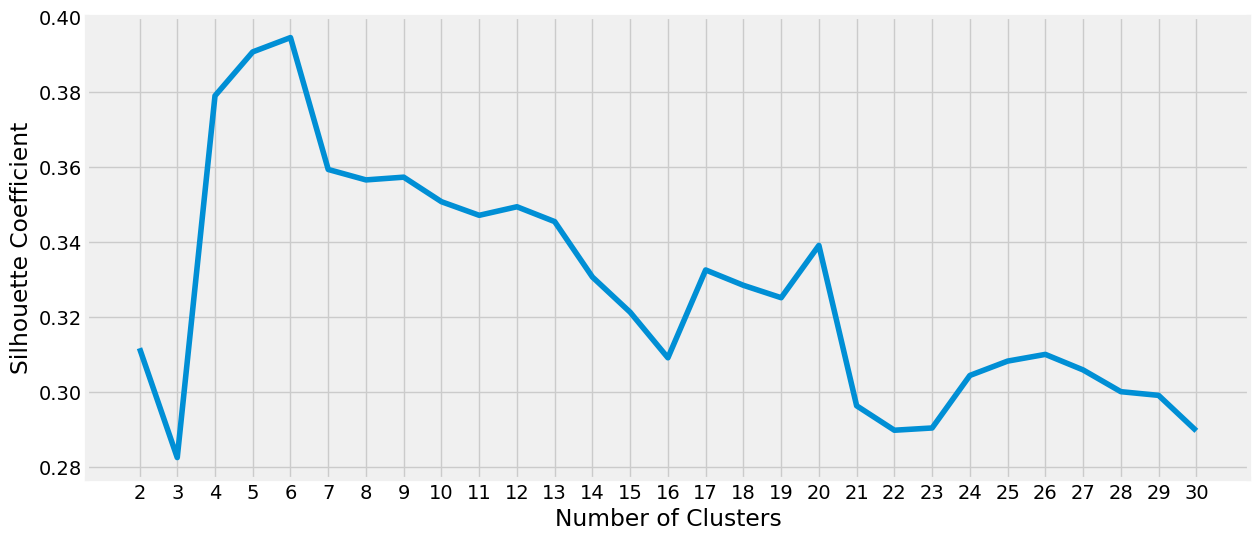

In [22]:
silhouette_coefficients = []

for k in range(2, 31):
    clusterer = KMeans(n_clusters = k, random_state=55,n_init= 'auto').fit(X)
    score = silhouette_score(X, clusterer.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize=(15,6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 31), silhouette_coefficients)
plt.xticks(range(2, 31))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

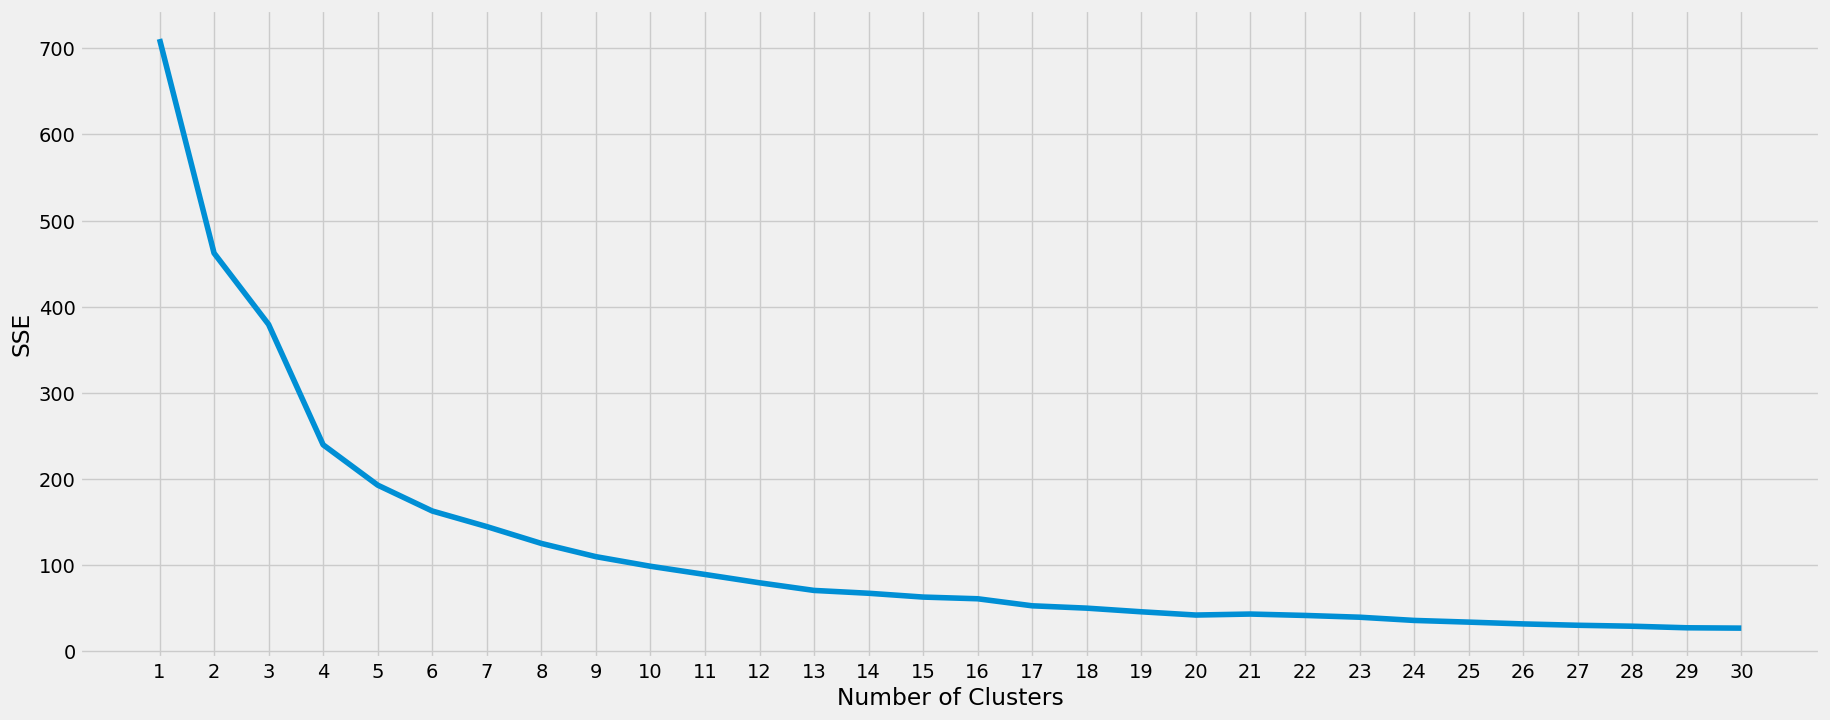

Optimal number of clusters based on elbow method:  6


In [23]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 31):
    clusterer = KMeans(n_clusters=k, random_state=55,n_init= 'auto').fit(X)
    sse.append(clusterer.inertia_)

plt.figure(figsize=(20,8))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 31), sse)
plt.xticks(range(1, 31))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(
    range(1, 31), sse, curve="convex", direction="decreasing"
)

print("Optimal number of clusters based on elbow method: ", kl.elbow)

Next we combined the coloring labeling of each host with the clusters identifed with Kmeans and labelled each host.

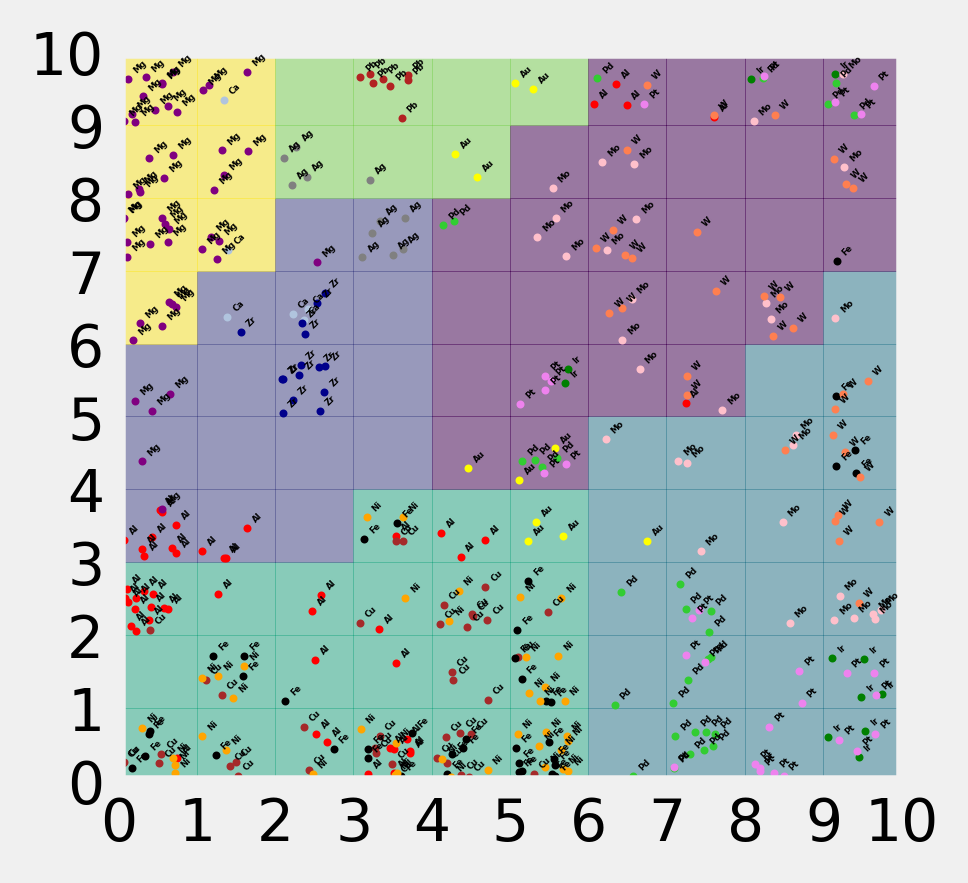

In [24]:
colors = {'Ag':'grey', 'Al':'red', 'Au': 'yellow', 'Ca':'lightsteelblue', 'Cu': 'brown', 'Fe': 'black', 'Ir': 'green', 'Mg':'purple', 'Mo': 'pink', 'Ni': 'orange', 'Pb':'firebrick',
       'Pd': 'limegreen', 'Pt': 'violet', 'W': 'coral', 'Zr': 'darkblue'}

kmeans = KMeans(n_clusters=6,random_state=55,n_init= 'auto').fit(X)
cluster = []
fig = plt.figure(figsize=(3, 3),dpi=300)
ax = fig.add_subplot(111)

kmeans_cluster = kmeans.labels_.reshape(size,size)
kmeans_cluster_flip = np.rot90(np.fliplr(kmeans_cluster))

plt.pcolor(kmeans_cluster_flip,alpha=0.5)


for index, datapoint in enumerate(traindata):
    # find the best matching unit of the datapoint
    w = som.winner(datapoint)
    x_coord = w[0]+np.random.uniform(0.05,0.75)
    y_coord = w[1]+np.random.uniform(0.05,0.75)

    #adds host label to each point and varries space to show all points
    plt.text(x_coord+0.05,y_coord+0.05,(df_SOM.iloc[index]['host']),
            horizontalalignment='left', verticalalignment='bottom',
            rotation=45, fontsize=2, weight='semibold')

    #tracks Kmeans cluster for each datapoint
    #NOT MATCHING COLORS on graph
    cluster.append(kmeans_cluster[w])

    #makes color based on host and plots best matching unit
    color = colors[df_SOM.iloc[index]['host']]
    plt.scatter(x_coord,y_coord,c=color,s=2)

#visualize the grid
plt.ylim(0,size)
plt.xlim(0,size)
ax.set_xticks(range(size+1))
ax.set_yticks(range(size+1))
plt.grid()

Now we can look at each of the features that are being used in the model to see how they trend with the clusters to see what features have an impact in some regions.

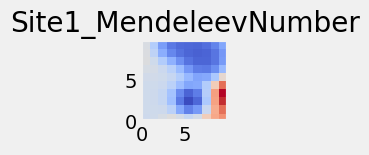

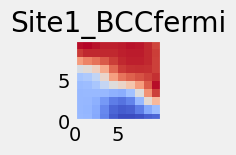

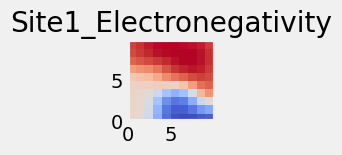

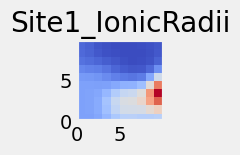

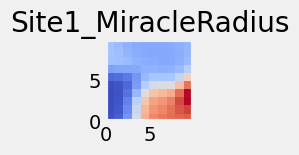

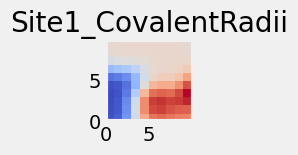

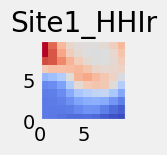

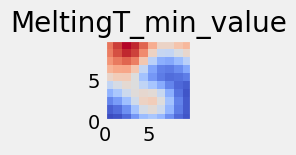

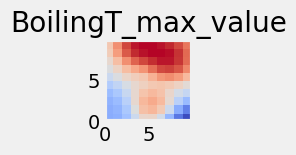

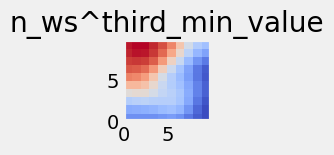

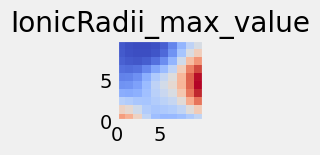

In [25]:
titles = ['Site1_MendeleevNumber', 'Site1_BCCfermi',
       'Site1_Electronegativity', 'Site1_IonicRadii', 'Site1_MiracleRadius',
       'Site1_CovalentRadii', 'Site1_HHIr', 'MeltingT_min_value',
       'BoilingT_max_value', 'n_ws^third_min_value', 'IonicRadii_max_value',
       'MiracleRadius_min_value', 'GSestFCClatcnt_max_value',
       'CovalentRadius_max_value', 'NUnfilled_max_value',
       'valence_arithmetic_average', 'SpecificHeatCapacity_difference']


for i in range(11):
    plt.figure(figsize=(1, 1))
    plt.title(titles[i])
    plt.pcolor(W[:,:,i], cmap='coolwarm')
    plt.xticks(np.arange(0,size,5))
    plt.yticks(np.arange(0,size,5))
    plt.show()

#Artificial Neural Network

This code is to be set up to handle a multiclass classification problem to predicts classes based on features. The model architecture consists of an input layer with the number of input features, a hidden layer, and an output layer with a 'softmax' activation for multiclass classification.
Overall, the code aims to preprocess the data, build a multiclass classification model using a neural network (MLP), and train the model to predict  'Material compositions 1' based on the input features.



In [26]:
# Separate the features (X) and the target variable (y)
X = df_updated.drop(columns=['Material compositions 1'])  # All columns except 'Material 1' as features
y = df_updated['Material compositions 1']  # Target variable

for i in range(len(df_updated)):
    if df_updated['Material compositions 1'][i] in ['Acceptable', 'Limited use', 'Unacceptable']:
        y[i] = 'Other'

# Encode categorical target variable 'Material 1'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define and compile the ANN model
def multiclass_nn_builder():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X.shape[1]))  # Input layer
    model.add(Dense(units=32, activation='relu'))  # Hidden layer
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))  # Output layer for categorical prediction

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build the multiclass model using label encoded data
multiclass_model = multiclass_nn_builder()
# Train the model
history = multiclass_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
11/11 [==============================] - 1s 23ms/step - loss: 2.7668 - accuracy: 0.0552 - val_loss: 2.6628 - val_accuracy: 0.0732
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 2.5164 - accuracy: 0.1503 - val_loss: 2.4440 - val_accuracy: 0.2805
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 2.3074 - accuracy: 0.4080 - val_loss: 2.2464 - val_accuracy: 0.4634
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 2.1055 - accuracy: 0.5061 - val_loss: 2.0420 - val_accuracy: 0.5244
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 1.9012 - accuracy: 0.5491 - val_loss: 1.8492 - val_accuracy: 0.5732
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 1.6969 - accuracy: 0.5920 - val_loss: 1.6634 - val_accuracy: 0.5976
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 1.4975 - accuracy: 0.6442 - val_loss: 1.4777 - val_accuracy: 0.6463
Epoch 8/100


In [27]:
y_test_predict = (multiclass_model.predict(X_test) > 0.5).astype("int32")
# Evaluate the model
loss, accuracy = multiclass_model.evaluate(X_test, y_test)
print(f"Loss on Test Data: {loss:.3f}")
print(f"Accuracy on Test Data: {accuracy:.3f}")

3/3 [==============================] - 0s 4ms/step - loss: 0.2357 - accuracy: 0.9634
Loss on Test Data: 0.236
Accuracy on Test Data: 0.963



The training results of the Artificial Neural Network (ANN) model look quite promising:

The training accuracy steadily increases over epochs, reaching 100% accuracy on the training data.
The validation accuracy also shows an increasing trend and stabilizes around 96.34% accuracy on the validation data.
The loss function (categorical cross-entropy) decreases consistently both for the training and validation datasets, indicating that the model is learning and generalizing well without overfitting.
These results suggest that the model is learning the patterns in the data effectively and performing well not only on the training set but also on the unseen validation data, which is a good sign of generalization.

The final evaluation on the test set showed an accuracy of 96.34%, which aligns with the validation accuracy. This indicates that the model is performing consistently across different unseen datasets.

These results demonstrate that the ANN model has learned the patterns in the data well and can make accurate predictions on new, unseen instances. However, further evaluation and fine-tuning of the models hyperparameters is needed to ensure  robustness and generalization.

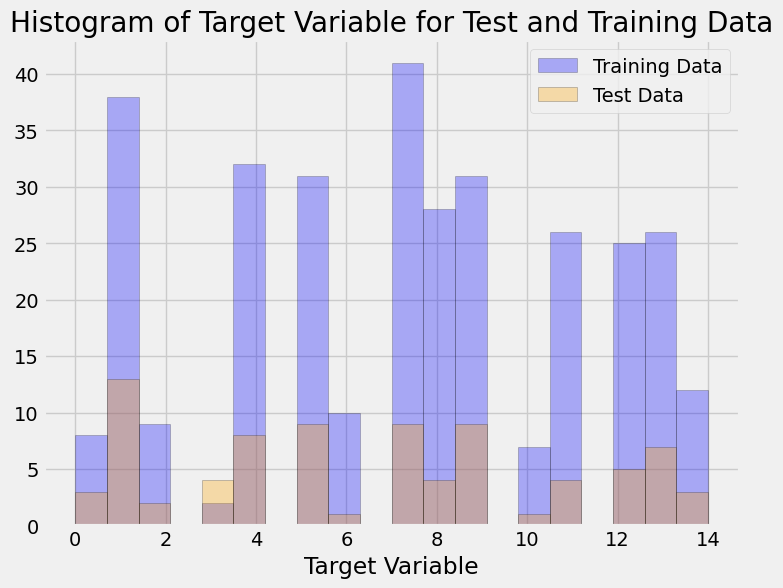

In [28]:
#Plot of Histograms for Test and Training Data:
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=20, alpha=0.3, color='blue', edgecolor='black', label='Training Data')
plt.hist(y_test, bins=20, alpha=0.3, color='orange', edgecolor='black', label='Test Data')
plt.xlabel('Target Variable')
plt.ylabel('')
plt.title('Histogram of Target Variable for Test and Training Data')
plt.legend()
plt.show()

In [29]:
# Scatter plot of the target and trained data
predictions = model.predict(X_train)
plt.figure(figsize=(8, 6))
plt.scatter(y_train, predictions, label='Trained Data')
plt.plot(y_train, y_train, color='red', label='Linear Fit')  # Linear fit line (ideal case)
plt.title('Linear Fit of Target vs Trained Data')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.legend()
plt.grid()
plt.show()

NameError: ignored

In [ ]:
# Plot of training epochs versus error for validation and training data
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Histoy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Perform dimensionality reduction using PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features for PCA
pca = PCA(n_components=2)  # Use 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Train the model
multiclass_model.fit(X_scaled, y_encoded, epochs=100, batch_size=32)

# Plot the decision boundary in the reduced space (2D)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', label='Data points')
plt.title('Data points with Decision Boundary (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# To plot decision boundary, * can use meshgrid and model predictions
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = multiclass_model.predict_classes(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.colorbar()
plt.legend()
plt.show()

In [ ]:
predicted_values = model.predict(X_test)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for Test Data with labels
for i, (x1, x2, y_actual, y_predicted) in enumerate(zip(X_test.iloc[:, 0], X_test.iloc[:, 1], y_test, predicted_values)):
    ax.scatter(x1, x2, y_actual, c='red', marker='^')  # Actual Material 1
    ax.scatter(x1, x2, y_predicted, c='green', marker='s')  # Predicted Material 1

    # Add annotations for material labels
    ax.text(x1, x2, y_actual, df.iloc[i]['Material compositions 1'], color='black', fontsize=8)
    ax.text(x1, x2, y_predicted, df.iloc[i]['Material compositions 1'], color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Material 1')
ax.set_title('3D Scatter Plot of Actual vs Predicted Material 1')

# Show plot
plt.show()

#Conclusions
From the three models above, [insert conclusions]